# 1.A. Creating an instance of a dynamical system

### What _is_ a dynamical system?

A "dynamical system" is a rule that describes how some variables $\vec{u}$ should evolve in time. This law is described by the "equations of motion" function $\vec{f}$.

There are two types of dynamical systems (in our case):

1. One is called a map, where time is a discrete quantity (like "steps" or "generations"). The equations of motion then look something like $\vec{u}_{n+1} = \vec{f}(\vec{u}_n, p, n)$ where $n$ is an integer and $p$ are the parameters of the system.

2. The other type is called an Ordinary Differential Equation (ODE), where time is a continuous quantity. Then, the equations of motion give the time derivatives of the variables: $\frac{d\vec{u}}{dt} = \vec{f}(\vec{u}, p, t)$.

In both cases $\vec{u}$ is the state of the system, a vector of the variables that define the system. For example, $\vec{u}$ may be defined as $(x, y, z)$, or as $(\theta, I)$, or as $(V, I, R, C_1, C_2)$, etc.

---


## Creating a simple discrete system


A `DynamicalSystem` is a Julia `struct` that contains all the information of a dynamical system:
1. Equations of motion function $\vec{f}$
3. Initial state.
4. Parameter container (if the equations of motion are parameterized).
5. Jacobian of the equations of motion.

---

For simplicity let's focus on creating a simple discrete chaotic system, the [Hénon map](https://en.wikipedia.org/wiki/H%C3%A9non_map). 

The constructor we need is:

```julia
DiscreteDynamicalSystem(eom, state, p)
```

In order to construct a Hénon map, let's discuss the input arguments we need to pass to this constructor!

### (1) Equations of motion
The first argument of the above constructor -`eom`- is a **function** representing the equations of motion.

Therefore, the first step in creating a `DynamicalSystem` is to define the equations of motion. For the Hénon map they have the form:

$$
\begin{aligned}
x_{n+1} &= 1 - ax^2_n+y_n \\
y_{n+1} & = bx_n
\end{aligned}
$$

Now we must make a function out of them. There is some strictness when writing this function in Julia. Specifically, it can only be one of two forms: out-of-place (oop) or in-place (iip). Here is how to define it:

* **oop** : The `eom` function **must** be in the form `eom(x, p, t) -> SVector`
  which means that given a state `x::SVector` and some parameter container
  `p` it returns a [`SVector`](http://juliaarrays.github.io/StaticArrays.jl/stable/pages/api.html#SVector-1)
  (from the [StaticArrays](https://github.com/JuliaArrays/StaticArrays.jl) module)
  containing the next state.
* **iip** : The `eom` function **must** be in the form `eom!(xnew, x, p, t)`
  which means that given a state `x::Vector` and some parameter container `p`,
  it writes in-place the new state in `xnew`.

We advise to use **oop** for systems with dimension < 11, and use **iip** otherwise.

*If you are familiar with [DifferentialEquations.jl](http://docs.juliadiffeq.org/latest/), then notice that the equations of motion are defined in an identical manner*

---

Because the Hénon map is only 2-dimensional, we follow the advice of the documentation and take advantage of the [`StaticArrays`](https://github.com/JuliaArrays/StaticArrays.jl) module.

In [5]:
using DynamicalSystems, Plots

In [6]:
h_eom(x, p, t) = SVector{2}(1 - p[1]x[1]^2 + x[2], p[2]*x[1])

h_eom (generic function with 1 method)

* Remember: *both* `p` (for parameters) and `t` (for time) must be included in the equations of motion function, irrespective of whether they are used or not!

### (2) Initial State

The second argument for the `DiscreteDynamicalSystem` constructor is a `state`, which represents the initial condition for the system:

In [7]:
state = SVector{2}(0., 0.) # doesn't matter if we use Vector of SVector for the `state`

2-element StaticArrays.SArray{Tuple{2},Float64,1,2} with indices SOneTo(2):
 0.0
 0.0

### (3) Parameters for the EOM

Then, the last argument, `p`, is simply a parameter container.It is best to use a mutable container that can be accessed with brackets (`getindex`).

In [8]:
p = [1.4, 0.3] # p = [a, b] from the equations of motion

2-element Array{Float64,1}:
 1.4
 0.3

These 3 things are enough to make a `DynamicalSystem`:

In [9]:
henon = DiscreteDynamicalSystem(h_eom, state, p)

2-dimensional discrete dynamical system
 state:       [0.0, 0.0]
 e.o.m.:      h_eom
 in-place?    false
 jacobian:    ForwardDiff
 parameters:  [1.4, 0.3]

In [12]:
henon.f(state, p, 0)

2-element StaticArrays.SArray{Tuple{2},Float64,1,2} with indices SOneTo(2):
 1.0
 0.0

# 2.B. Getting a trajectory

Now that we have created the system, the first (and most basic) thing to do is to simply plot its time evolution and see what it looks like. 

The `trajectory` function is a convenient tool that evolves the system and returns the output at equally spaced time intervals. The call signature is simply:

```julia
trajectory(ds::DynamicalSystem, T [, u]; kwargs...)
```
which evolves a system for total time `T`, optionally starting from a different state `u`.

In [6]:
# trajectory from initial condition
tr = trajectory(henon, 100000)

2-dimensional Dataset{Float64} with 100001 points
  0.0        0.0      
  1.0        0.0      
 -0.4        0.3      
  1.076     -0.12     
 -0.740886   0.3228   
  0.554322  -0.222266 
  0.347552   0.166297 
  0.997188   0.104265 
 -0.287871   0.299156 
  1.18314   -0.0863614
 -1.0461     0.354942 
 -0.177128  -0.313831 
  0.642244  -0.0531385
  ⋮                   
  0.582553   0.103    
  0.627885   0.174766 
  0.622831   0.188365 
  0.64528    0.186849 
  0.603908   0.193584 
  0.682997   0.181173 
  0.528095   0.204899 
  0.814462   0.158428 
  0.229742   0.244338 
  1.17044    0.0689225
 -0.848995   0.351133 
  0.342024  -0.254698 

trajectory returns an object that is a `Dataset`. A `Dataset` is a wrapper of `Vector{SVector}` that can be accessed like a matrix. More on `Dataset` on the chapter on `DelayEmbeddings`!

In [7]:
# trajectory from a different starting point
tr2 = trajectory(henon, 100000, 0.01rand(2))

2-dimensional Dataset{Float64} with 100001 points
  0.00985896   0.0074734 
  1.00734      0.00295769
 -0.417662     0.302201  
  1.05798     -0.125299  
 -0.692357     0.317395  
  0.646293    -0.207707  
  0.207521     0.193888  
  1.1336       0.0622563 
 -0.736803     0.340079  
  0.58005     -0.221041  
  0.307918     0.174015  
  1.04128      0.0923755 
 -0.425582     0.312383  
  ⋮                      
  1.26231      0.0131814 
 -1.21761      0.378693  
 -0.696922    -0.365284  
 -0.0452637   -0.209077  
  0.788055    -0.0135791 
  0.116978     0.236417  
  1.21726      0.0350933 
 -1.03932      0.365178  
 -0.147068    -0.311795  
  0.657925    -0.0441205 
  0.349868     0.197377  
  1.02601      0.104961  

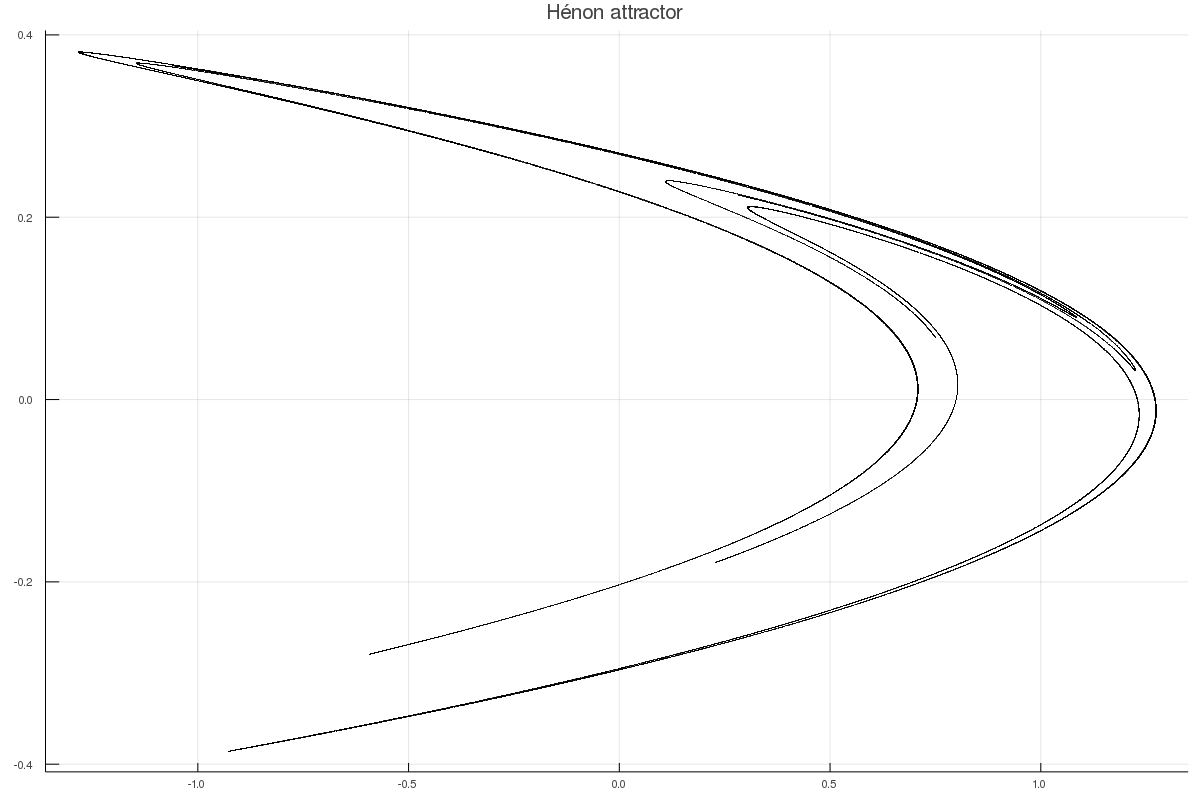

In [8]:
plotrange = 1000:100000
scatter(tr[plotrange,1], tr[plotrange,2], 
    markersize=0.1, markeralpha = 0.3, markercolor="black",
    leg=false, title="Hénon attractor", 
    html_output_format=:png, size=(1200,800))

# 1.C. Jacobian Function
Let's see `henon` again:

In [9]:
henon

2-dimensional discrete dynamical system
 state:       [0.0, 0.0]
 e.o.m.:      h_eom
 in-place?    false
 jacobian:    ForwardDiff
 parameters:  [1.4, 0.3]

* The last line, "`jacobian:  ForwardDiff`"
says that the Jacobian function of the equations of motion was computed automatically using the module [`ForwardDiff`](http://www.juliadiff.org/ForwardDiff.jl/stable/user/api.html). 
* The Jacobian function is a crucial component of a dynamical system, and that is why if it is not given, it is computed automatically.



Even though the automatic computation is very efficient, the best possible performance will come if you pass a "hard-coded" jacobian:

In [10]:
h_jacobian(x, p, t) = @SMatrix [-2*p[1]*x[1] 1.0; 
                                p[2]         0.0]

h_jacobian (generic function with 1 method)

* Notice that for **out-of-place** systems, the Jacobian must also have the same form as the equations of motion, namely to return an `SMatrix`.

Now, we can pass this Jacobian function to the `DiscreteDynamicalSystem` constructor as a 4th argument:

In [11]:
henon_with_jac = DiscreteDynamicalSystem(h_eom, state, p, h_jacobian)

2-dimensional discrete dynamical system
 state:       [0.0, 0.0]
 e.o.m.:      h_eom
 in-place?    false
 jacobian:    h_jacobian
 parameters:  [1.4, 0.3]

Even though `ForwardDiff` is truly performant, the hard-coded version should "always" be faster. 

*This becomes much more important for higher dimensional systems, especially for the in-place form!*

# Using labelled arrays

It is highly suggested to use a subtype of `Array`, [`LMArray`](https://github.com/JuliaDiffEq/LabelledArrays.jl) or a dictionary for the container of the model's parameters. Some functions offered by **DynamicalSystems.jl**, like e.g. [`orbitdiagram`](https://juliadynamics.github.io/DynamicalSystems.jl/latest/chaos/orbitdiagram/#ChaosTools.orbitdiagram), assume that the parameters can be first accessed by `p[x]` with `x` some qualifier as well as that this value can be set by `p[x] = newvalue`.

The [Labelled Arrays](https://github.com/JuliaDiffEq/LabelledArrays.jl) package offers `Array` implementations that can be accessed both by index as well as by some name.

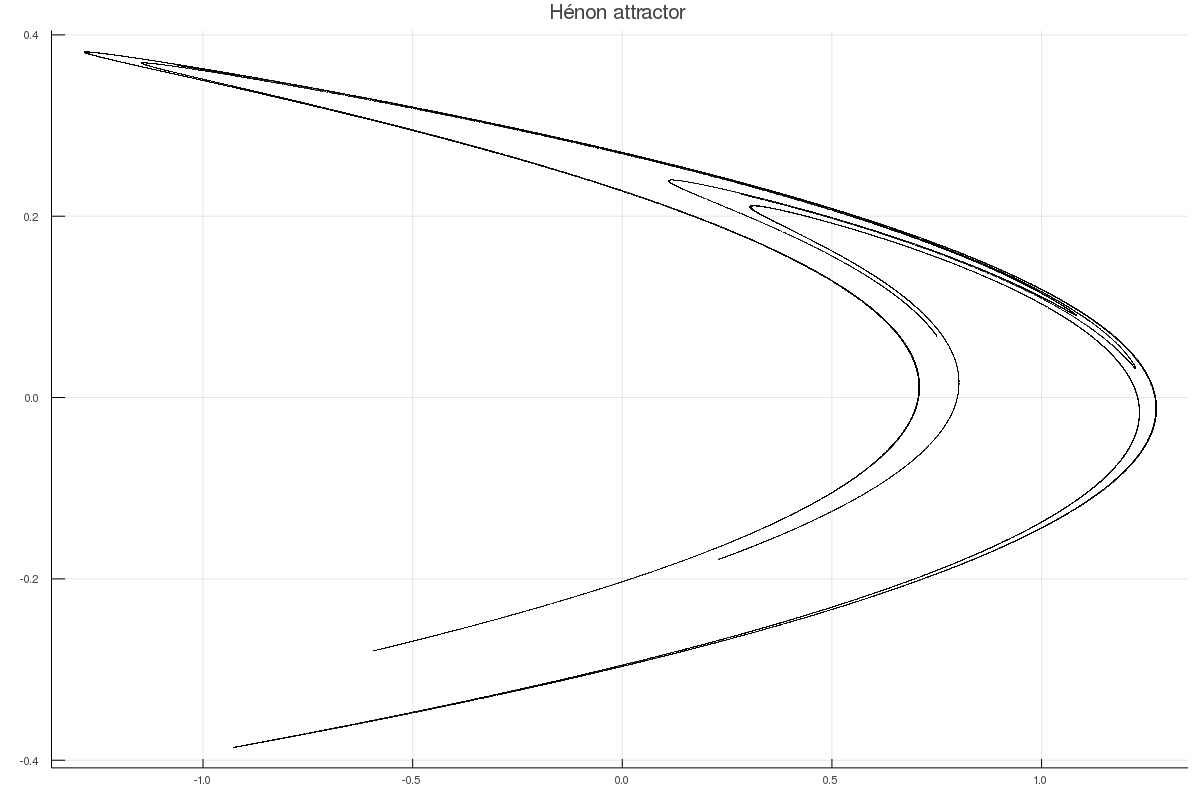

In [12]:
using LabelledArrays

state = SVector{2}(0., 0.)
p = SLVector(a=1.4, b=0.3) # A static labelled vector (1d array). 
# Labels are syntactically replaced by indicies, so they cost nothing to the computer!

# Notice how p[1], p[2] can be replaced by p.a, p.b
h_eom(x, p, t) = SVector{2}(1 - p.a * x[1]^2 + x[2], p.b*x[1])
h_jacobian(x, p, t) = @SMatrix [-2*p.a*x[1] 1.0; 
                                   p.b      0.0]

henon = DiscreteDynamicalSystem(h_eom, state, p, h_jacobian)
tr = trajectory(henon, 100000, 0.01rand(2))

plotrange = 1000:100000
scatter(tr[plotrange,1], tr[plotrange,2], 
    markersize=0.1, markeralpha = 0.3, markercolor="black",
    leg=false, title="Hénon attractor", 
    html_output_format=:png, size=(1200,800))

# 1.D. Identical handling for continuous and discrete systems
* The process of creating a continuous system is identical to that of a discrete system, except that the constructor `ContinuousDynamicalSystem` is used instead. 
* In this case the function `eom` returns the time derivatives and not a "next state".


---



* We will take the opportunity to show the process of using in-place equations of motion for a continuous system, which is aimed to be used for large systems (dimensionality $\ge$ 10). In general, in-place is suggested for big systems, whereas out-place is suggested for small systems. The break-even point at around 100 dimensions, and for using functions that use the tangent space (like e.g. `lyapunovs` or `gali`), the break-even point is at around 10 dimensions. See the [document](https://juliadynamics.github.io/DynamicalSystems.jl/latest/ds/general) for details.

* In addition, the system we will use (Henon-Heiles) does not have any parameters.

$$
\begin{aligned}
\dot{x} &= p_x \\
\dot{y} &= p_y \\
\dot{p}_x &= -x -2 xy \\
\dot{p}_y &= -y - (x^2 - y^2)
\end{aligned}
$$

In [13]:
# Henon-heiles famous system
# in-place form of equations of motion
# du is the derivatives vector, u is the state vector
function hheom!(du, u, p, t)
    du[1] = u[3]
    du[2] = u[4]
    du[3] = -u[1] - 2u[1]*u[2]
    du[4] = -u[2] - (u[1]^2 - u[2]^2)
    return nothing
end

# pass `nothing` as the parameters, because the system doesn't have any
hh = ContinuousDynamicalSystem(hheom!, [0, -0.25, 0.42081, 0], nothing)

4-dimensional continuous dynamical system
 state:       [0.0, -0.25, 0.42081, 0.0]
 e.o.m.:      hheom!
 in-place?    true
 jacobian:    ForwardDiff
 parameters:  nothing

Great, now we can get a trajectory of this system, by solving using DifferentialEquations.jl

In [14]:
tr = trajectory(hh, 100.0, dt = 0.05)

4-dimensional Dataset{Float64} with 2001 points
  0.0        -0.25      0.42081   0.0      
  0.0210361  -0.24961   0.420547  0.0156079
  0.0420459  -0.248441  0.419755  0.0311131
  0.0630027  -0.246502  0.418429  0.0464137
  0.0838797  -0.243805  0.416557  0.0614095
  0.104649   -0.240367  0.414125  0.0760025
  0.125283   -0.236213  0.411116  0.0900977
  0.145751   -0.231368  0.407508  0.103604 
  0.166023   -0.225864  0.403277  0.116435 
  0.186068   -0.219737  0.398396  0.128509 
  0.205851   -0.213026  0.392838  0.139751 
  0.22534    -0.205777  0.386572  0.150091 
  0.244496   -0.198033  0.379568  0.159466 
  ⋮                                        
 -0.116577   -0.263     0.370759  0.157468 
 -0.0979725  -0.254732  0.373344  0.17319  
 -0.0792484  -0.245689  0.375555  0.188442 
 -0.0604236  -0.235897  0.377364  0.20314  
 -0.0415192  -0.225386  0.378735  0.217205 
 -0.0225581  -0.214188  0.379631  0.230562 
 -0.0035648  -0.202342  0.38001   0.243138 
  0.0154336  -0.189889  0.37

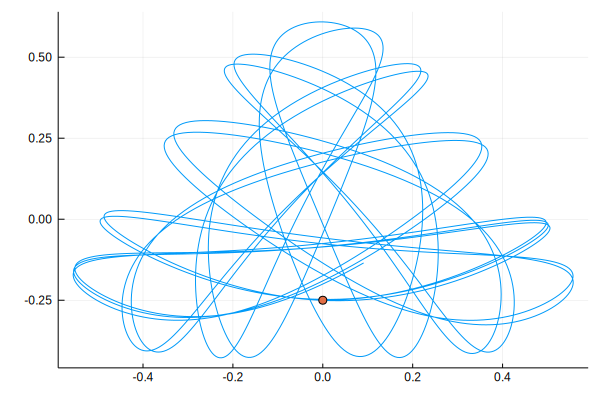

In [15]:
plot(tr[:, 1], tr[:, 2], leg=false)
scatter!([tr[1, 1]], [tr[1, 2]])

## DifferentialEquations.jl
Discrete systems are evolved using internal algorithms. However, all time evolution of continuous systems is done through the [DifferentialEquations.jl](http://docs.juliadiffeq.org/latest/) library. 

See `DynamicalSystemsBase.CDS_KWARGS` for the default options used to evolve continuous systems.

In [16]:
DynamicalSystemsBase.CDS_KWARGS

(alg = SimpleDiffEq.SimpleATsit5(), abstol = 1.0e-6, reltol = 1.0e-6)


It is almost certain that if you use **DynamicalSystems.jl** you want to use also DifferentialEquations.jl, due to the huge list of available features.


### Interface to DifferentialEquations.jl

```julia
ContinuousDynamicalSystem(prob::ODEProblem [, jacobian [, J0]])
ODEProblem(continuous_dynamical_system, tspan [; callback, mass_matrix])
```

---

In addition, almost all arguments that are passed to `solve` of DifferentialEquations.jl can be passed to any function that accepts a `ContinuousDynamicalSystem`. For example:

In [17]:
using OrdinaryDiffEq # access the solvers
diffeq = (alg = Tsit5(), rtol = 1e-3, dtmax = 0.01)

(alg = Tsit5(), rtol = 0.001, dtmax = 0.01)

In [18]:
tr2 = trajectory(hh, 100.0; diffeq...)

4-dimensional Dataset{Float64} with 10001 points
 0.0         -0.25      0.42081   0.0       
 0.00420806  -0.249984  0.420799  0.00312486
 0.00841592  -0.249938  0.420768  0.0062489 
 0.0126234   -0.249859  0.420715  0.0093713 
 0.0168302   -0.24975   0.420642  0.0124912 
 0.0210361   -0.24961   0.420547  0.0156079 
 0.025241    -0.249438  0.420431  0.0187204 
 0.0294447   -0.249235  0.420294  0.021828  
 0.0336468   -0.249001  0.420136  0.0249298 
 0.0378473   -0.248737  0.419956  0.0280251 
 0.0420459   -0.248441  0.419755  0.0311131 
 0.0462423   -0.248114  0.419533  0.0341928 
 0.0504365   -0.247757  0.419289  0.0372635 
 ⋮                                          
 0.0494465   -0.16605   0.377898  0.273739  
 0.0532237   -0.163303  0.377554  0.27563   
 0.0569974   -0.160537  0.377181  0.277481  
 0.0607673   -0.157753  0.37678   0.279291  
 0.0645329   -0.154951  0.376349  0.28106   
 0.0682942   -0.152132  0.375889  0.282787  
 0.0720506   -0.149296  0.375399  0.284472  
 0.075

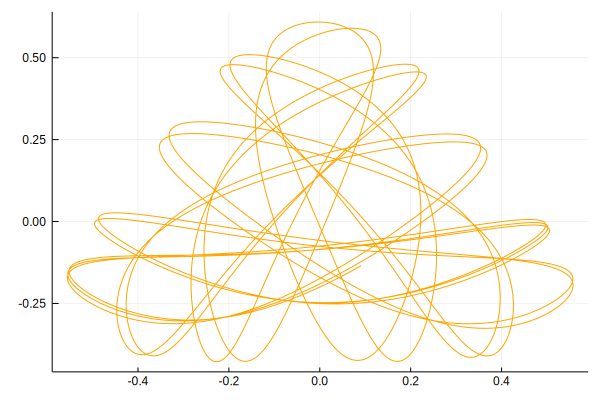

In [19]:
plot(tr2[:, 1], tr2[:, 2], color = :orange, leg=false)